In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

# F1 data
import fastf1 as f1

In [2]:
f1.Cache.enable_cache("cache")

schedule = pd.DataFrame(f1.get_event_schedule(2025).iloc[1:])
print(schedule.columns)

schedule = schedule[['RoundNumber', 'EventName', 'EventFormat']]

schedule['SprintWeekend'] = schedule['EventFormat'].apply(lambda x: True if x.startswith('sprint') else False)

schedule.drop(columns = ['EventFormat'], inplace=True)

schedule.head()

Index(['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate',
       'EventName', 'EventFormat', 'Session1', 'Session1Date',
       'Session1DateUtc', 'Session2', 'Session2Date', 'Session2DateUtc',
       'Session3', 'Session3Date', 'Session3DateUtc', 'Session4',
       'Session4Date', 'Session4DateUtc', 'Session5', 'Session5Date',
       'Session5DateUtc', 'F1ApiSupport'],
      dtype='object')


,RoundNumber,EventName,SprintWeekend
1,1,Australian Grand Prix,False
2,2,Chinese Grand Prix,True
3,3,Japanese Grand Prix,False
4,4,Bahrain Grand Prix,False
5,5,Saudi Arabian Grand Prix,False


In [3]:
all_results = pd.read_csv("all_results.csv", index_col=0)

year = 2025

season = f1.get_event_schedule(year)
season = season[~season.is_testing()]

for index, event in season.iterrows():
    if (event['EventDate'] > pd.Timestamp.today()):
        break
    name = event['EventName']

    event = f1.get_event(year, name)
    race = event.get_race()
    race.load(weather=True)

    results = race.results
    

    results = results[['Abbreviation', 'TeamId', 'GridPosition', 'Position', 'Time', 'Status']]

    results.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

    results['Race'] = event['EventName']

    results['TotalTime'] = results['Time']

    leading = 0
    for i in range(1, len(results)):
        if(results['Time'].iloc[i] < results['Time'].iloc[i-1]):
            leading = i-1
        results['TotalTime'].iloc[i] = results['TotalTime'].iloc[leading] + results['Time'].iloc[i]
        

    results["Time"] = results["TotalTime"].astype('int64').replace(-9223372036854775808, np.nan)
    results = results.drop(columns = ['TotalTime'])

    rain = race.weather_data['Rainfall']        
    rain_score = rain.sum() / len(rain)
    results['Rain'] = rain_score
    
    all_results = pd.concat([all_results, results], ignore_index=True)



core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', 

In [4]:
all_results.head()

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0


In [5]:
all_results.tail()

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain
1434,LAW,rb,17.0,16.0,5.803870e+12,Finished,Bahrain Grand Prix,0.0
1435,STR,aston_martin,19.0,17.0,5.804924e+12,Finished,Bahrain Grand Prix,0.0
1436,BOR,sauber,18.0,18.0,5.806307e+12,Finished,Bahrain Grand Prix,0.0
1437,SAI,williams,8.0,19.0,NaN,Retired,Bahrain Grand Prix,0.0
1438,HUL,sauber,16.0,20.0,NaN,Disqualified,Bahrain Grand Prix,0.0


In [6]:
print(all_results['Status'].unique())
classified = ['Finished', '+1 Lap', '+2 Laps', '+6 Laps', 'Lapped']

['Finished' 'Fuel pressure' 'Power Unit' '+1 Lap' 'Collision damage'
 'Cooling system' 'Water pump' 'Gearbox' 'Accident' 'Withdrew' 'Fuel leak'
 'Spun off' 'Collision' 'Front wing' 'Suspension' 'Water leak' '+2 Laps'
 'Power loss' 'Turbo' 'Mechanical' 'Water pressure' 'Vibrations'
 'Hydraulics' 'Engine' 'Fuel pump' 'Undertray' '+6 Laps' 'Differential'
 'Oil leak' 'Lapped' 'Retired' 'Did not start' 'Disqualified']


In [7]:
all_results['ClassifiedPosition'] = all_results.apply(lambda row: np.nan if row['Status'] not in classified else row['Position'], axis=1)
all_results

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain,ClassifiedPosition
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0,1.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0,2.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0,3.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0,4.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0,5.0
...,...,...,...,...,...,...,...,...,...
1434,LAW,rb,17.0,16.0,5.803870e+12,Finished,Bahrain Grand Prix,0.0,16.0
1435,STR,aston_martin,19.0,17.0,5.804924e+12,Finished,Bahrain Grand Prix,0.0,17.0
1436,BOR,sauber,18.0,18.0,5.806307e+12,Finished,Bahrain Grand Prix,0.0,18.0
1437,SAI,williams,8.0,19.0,NaN,Retired,Bahrain Grand Prix,0.0,NaN


In [8]:
all_results = all_results.drop(columns=['GridPosition', 'Time', 'Status'])
all_results.columns

Index(['Driver', 'TeamId', 'Position', 'Race', 'Rain', 'ClassifiedPosition'], dtype='object')

In [9]:
drivers = all_results['Driver'].unique()
drivers
teams = all_results['TeamId'].unique()
teams

array(['ferrari', 'mercedes', 'haas', 'sauber', 'alpine', 'rb',
       'aston_martin', 'williams', 'mclaren', 'red_bull'], dtype=object)

In [10]:
current_drivers = ['NOR', 'PIA', 'LEC', 'HAM', 'VER', 'TSU', 'OCO', 'BEA', 'LAW', 'HAD', 'ANT', 'RUS', 'GAS', 'DOO', 'ALO', 'STR', 'HUL', 'BOR', 'SAI', 'ALB']

### Adding hand written test inputs

In [11]:
race = 'Saudi Arabian Grand Prix'
round = 5

In [12]:
test = pd.DataFrame([["NOR", "mclaren"], ["PIA", "mclaren"],
                     ["LEC", "ferrari"], ["HAM", "ferrari"],
                     ["VER", "red_bull"], ["TSU", "red_bull"],
                     ["OCO", "haas"], ["BEA", "haas"],
                     ["LAW", "rb"], ["HAD", "rb"],
                     ["ANT", "mercedes"], ["RUS", "mercedes"],
                     ["GAS", "alpine"], ["DOO", "alpine"],
                     ["ALO", "aston_martin"], ["STR", "aston_martin"],
                     ["HUL", "sauber"], ["BOR", "sauber"],
                     ["SAI", "williams"], ["ALB", "williams"]])

test.columns = ['Driver', 'TeamId']
test['Race'] = race
test['Rain'] = 'None'

In [13]:
all_results = pd.concat([all_results, test], ignore_index=True)

test.drop(test.index, inplace=True)

all_results.tail()

,Driver,TeamId,Position,Race,Rain,ClassifiedPosition
1454,STR,aston_martin,NaN,Saudi Arabian Grand Prix,None,NaN
1455,HUL,sauber,NaN,Saudi Arabian Grand Prix,None,NaN
1456,BOR,sauber,NaN,Saudi Arabian Grand Prix,None,NaN
1457,SAI,williams,NaN,Saudi Arabian Grand Prix,None,NaN
1458,ALB,williams,NaN,Saudi Arabian Grand Prix,None,NaN


### Calculating lagged performcane metrics

In [14]:
driver_lagged = pd.DataFrame()

ls = []
for driver in drivers:
    dr = all_results[all_results['Driver'] == driver]
    dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
    dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
    dr['DriverLast3'] = dr['DriverLast1'].rolling(window=3, min_periods=1).mean()
    dr['DriverLast5'] = dr['DriverLast1'].rolling(window=5, min_periods=1).mean()
    dr['DriverLast10'] = dr['DriverLast1'].rolling(window=10, min_periods=1).mean()

    if driver in current_drivers:
        ls.append(dr[:-1])
        test = pd.concat([test, pd.DataFrame(dr[-1:])], ignore_index=True)
    else:
        ls.append(dr)

driver_lagged = pd.concat(ls, ignore_index=False)
driver_lagged = driver_lagged.sort_index()

C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2739688924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2739688924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2739688924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [15]:
driver_lagged = pd.concat([driver_lagged, test], ignore_index=True)
test.drop(test.index, inplace=True)

In [16]:
dataset = driver_lagged.sort_index()

### Adding lagged performance metrics

In [17]:
ls = []
for team in teams:
    tm = dataset[dataset['TeamId'] == team]

    tm['Group'] = np.floor(np.arange(len(tm)) / 2)

    race_avg = tm.groupby('Group')['DriverLast1'].transform('mean')
    rolling_3 = race_avg.rolling(window=3, min_periods=1).mean()
    rolling_5 = race_avg.rolling(window=5, min_periods=1).mean()
    rolling_10 = race_avg.rolling(window=10, min_periods=1).mean()

    tm['TeamLast1'] = race_avg
    tm['TeamLast3'] = rolling_3
    tm['TeamLast5'] = rolling_5
    tm['TeamLast10'] = rolling_10
    
    ls.append(tm[:-2])

    test = pd.concat([test, pd.DataFrame(tm[-2:])], ignore_index=True)
    
dataset = pd.concat(ls, ignore_index=False)


C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2156668681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tm['Group'] = np.floor(np.arange(len(tm)) / 2)
C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2156668681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tm['TeamLast1'] = race_avg
C:\Users\abdul\AppData\Local\Temp\ipykernel_27656\2156668681.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [18]:
bins = [-0.001, 0, 0.1, 0.5, dataset['Rain'].max() + 0.001]
labels = ['None', 'Light', 'Moderate', 'Heavy']

dataset['Rain'] = pd.cut(dataset['Rain'], bins=bins, labels=labels)

In [19]:
dataset.columns

Index(['Driver', 'TeamId', 'Position', 'Race', 'Rain', 'ClassifiedPosition',
       'DriverLast1', 'DriverLast3', 'DriverLast5', 'DriverLast10', 'Group',
       'TeamLast1', 'TeamLast3', 'TeamLast5', 'TeamLast10'],
      dtype='object')

In [20]:
dataset = dataset.drop(columns=['ClassifiedPosition', 'Group'])
dataset.sort_index()
test = test[dataset.columns]
dataset = dataset.sort_index()

In [21]:
# Define features
categorical_features = ['Driver', 'TeamId', 'Race', 'Rain']
numerical_features = [col for col in dataset.columns 
                      if col not in categorical_features + ['Position', 'ClassifiedPosition']]

# Drop rows with missing target
dataset = dataset.dropna()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='error'), categorical_features)
])

# Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


## Fitting the model with the dataset

In [22]:
# Features and target
X = dataset[categorical_features + numerical_features]
print(X['Driver'].unique())
y = dataset['Position']

model_pipeline.fit(X, y)

# Define K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(model_pipeline, X, y, cv=kfold, scoring="neg_mean_absolute_error")

print(mae_scores.mean())

['LEC' 'SAI' 'RUS' 'OCO' 'NOR' 'MAG' 'HAM' 'ZHO' 'HUL' 'STR' 'ALB' 'BOT'
 'ALO' 'RIC' 'LAT' 'TSU' 'PER' 'GAS' 'MSC' 'VER' 'VET' 'DEV' 'SAR' 'PIA'
 'LAW' 'COL' 'BEA' 'DOO' 'ANT' 'HAD' 'BOR']
-3.535535688684076


In [23]:
test = test.drop(columns=['Position'])

In [24]:
X = test[categorical_features + numerical_features]
pred = pd.DataFrame(model_pipeline.predict(X))
print(pred.var())

0    18.853466
dtype: float64


In [25]:
pred.columns = ["Position"]

prediction = pd.concat([test, pred], axis=1)

prediction = prediction.sort_values(by='Position', ascending=True)

prediction


,Driver,TeamId,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
2,RUS,mercedes,Saudi Arabian Grand Prix,None,2.0,3.333333,3.600000,3.800000,6.5,5.833333,5.3,5.15,4.30
0,LEC,ferrari,Saudi Arabian Grand Prix,None,4.0,5.333333,5.400000,4.200000,4.5,5.166667,6.7,6.25,4.50
1,HAM,ferrari,Saudi Arabian Grand Prix,None,5.0,7.333333,7.200000,7.000000,4.5,4.833333,5.8,6.30,4.74
17,PIA,mclaren,Saudi Arabian Grand Prix,None,1.0,1.666667,4.800000,5.500000,2.0,2.166667,2.1,3.30,4.86
19,VER,red_bull,Saudi Arabian Grand Prix,None,6.0,3.666667,3.800000,3.500000,7.5,7.166667,7.6,9.00,5.73
3,ANT,mercedes,Saudi Arabian Grand Prix,None,11.0,7.666667,6.750000,6.750000,6.5,6.166667,5.7,5.00,5.86
16,NOR,mclaren,Saudi Arabian Grand Prix,None,3.0,2.333333,1.800000,3.700000,2.0,2.333333,2.0,3.75,6.69
8,GAS,alpine,Saudi Arabian Grand Prix,None,7.0,10.333333,9.800000,8.200000,10.5,12.833333,12.5,11.55,11.86
4,OCO,haas,Saudi Arabian Grand Prix,None,8.0,10.333333,12.200000,12.400000,9.0,12.333333,10.0,11.45,12.66
18,TSU,red_bull,Saudi Arabian Grand Prix,None,9.0,12.333333,12.200000,11.800000,7.5,6.833333,8.1,8.80,12.87


In [26]:
australia = dataset[(1-round)*20 : (2-round)*20].reset_index(drop=True)
china = dataset[(2-round)*20 : (3-round)*20].reset_index(drop=True)
japan = dataset[(3-round)*20 : (4-round)*20].reset_index(drop=True)
bahrain = dataset[(4-round)*20:].reset_index(drop=True)

previous = [australia, china, japan, bahrain]

In [27]:
predictions = []

for race in previous:
    test = race
    
    test.rename(columns={'Position': 'TruePosition'}, inplace=True)

    X = test[categorical_features + numerical_features]

    pred = pd.DataFrame(model_pipeline.predict(X))
    print(pred.var())

    pred.columns = ["Position"]

    pred = pd.concat([test, pred], axis=1)

    pred = pred.sort_values(by='Position', ascending=True) 
    predictions.append(pred)

    mae = mean_absolute_error(pred['TruePosition'], pred['Position'])
    print(mae)


0    18.469192
dtype: float64
1.5595000000000003
0    21.736192
dtype: float64
1.9544999999999995
0    24.388405
dtype: float64
1.1395
0    22.927362
dtype: float64
1.248


In [28]:
predictions[0]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
6,VER,red_bull,2.0,Australian Grand Prix,Moderate,6.0,4.000000,3.800000,3.700000,11.5,7.500000,7.5,7.75,3.57
5,NOR,mclaren,1.0,Australian Grand Prix,Moderate,1.0,5.666667,5.000000,3.800000,5.5,6.166667,6.3,6.00,4.01
7,RUS,mercedes,3.0,Australian Grand Prix,Moderate,5.0,3.333333,3.800000,4.600000,5.0,7.000000,4.8,5.30,4.08
11,LEC,ferrari,8.0,Australian Grand Prix,Moderate,3.0,3.000000,3.400000,2.900000,3.5,3.833333,3.7,3.00,7.67
12,PIA,mclaren,9.0,Australian Grand Prix,Moderate,10.0,6.666667,7.200000,5.100000,5.5,5.833333,6.1,6.10,8.10
8,ALB,williams,5.0,Australian Grand Prix,Moderate,11.0,14.000000,14.800000,12.700000,12.5,13.166667,14.0,14.20,8.48
10,HUL,sauber,7.0,Australian Grand Prix,Moderate,8.0,8.000000,8.400000,9.800000,8.0,9.000000,11.6,13.30,8.93
13,HAM,ferrari,10.0,Australian Grand Prix,Moderate,4.0,6.000000,6.400000,6.600000,3.5,3.666667,3.7,3.20,9.17
9,STR,aston_martin,6.0,Australian Grand Prix,Moderate,14.0,14.666667,13.200000,14.600000,11.5,11.166667,11.9,12.25,9.74
14,GAS,alpine,11.0,Australian Grand Prix,Moderate,7.0,5.000000,5.600000,9.300000,11.0,7.000000,8.2,8.40,11.47


In [29]:
predictions[1]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
3,NOR,mclaren,2.0,Chinese Grand Prix,None,1.0,4.000000,4.80,3.80,5.0,5.166667,5.5,6.10,2.69
4,RUS,mercedes,3.0,Chinese Grand Prix,None,3.0,4.000000,3.40,4.20,3.5,4.500000,5.9,5.10,3.68
2,PIA,mclaren,1.0,Chinese Grand Prix,None,9.0,7.333333,7.40,5.60,5.0,5.333333,5.8,6.10,4.53
5,VER,red_bull,4.0,Chinese Grand Prix,None,2.0,3.000000,3.00,3.70,9.5,10.833333,8.7,8.20,4.60
7,ANT,mercedes,6.0,Chinese Grand Prix,None,4.0,4.000000,4.00,4.00,3.5,4.000000,5.0,5.00,5.04
6,OCO,haas,5.0,Chinese Grand Prix,None,13.0,15.666667,12.40,13.70,13.5,14.166667,11.9,10.50,7.96
9,BEA,haas,8.0,Chinese Grand Prix,None,14.0,12.000000,10.75,10.75,13.5,13.833333,12.9,10.90,9.95
10,STR,aston_martin,9.0,Chinese Grand Prix,None,6.0,11.666667,12.20,13.90,7.5,10.166667,10.5,11.55,10.42
8,ALB,williams,7.0,Chinese Grand Prix,None,5.0,10.333333,12.60,11.80,3.5,6.500000,9.3,12.10,10.45
11,SAI,williams,10.0,Chinese Grand Prix,None,2.0,3.333333,2.80,4.60,4.5,3.833333,7.3,11.15,10.49


In [30]:
predictions[2]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
1,NOR,mclaren,2.0,Japanese Grand Prix,None,2.0,1.333333,4.000000,3.700000,1.5,3.833333,4.5,5.55,2.94
0,VER,red_bull,1.0,Japanese Grand Prix,None,4.0,4.000000,3.600000,3.500000,10.0,9.666667,10.4,8.40,2.99
2,PIA,mclaren,3.0,Japanese Grand Prix,None,1.0,6.666667,6.000000,5.500000,1.5,2.666667,3.7,5.00,3.97
4,RUS,mercedes,5.0,Japanese Grand Prix,None,3.0,3.666667,3.200000,3.800000,4.5,3.833333,4.3,4.75,4.30
3,LEC,ferrari,4.0,Japanese Grand Prix,None,8.0,6.333333,5.000000,4.100000,9.0,9.000000,6.8,5.20,4.56
5,ANT,mercedes,6.0,Japanese Grand Prix,None,6.0,5.000000,5.000000,5.000000,4.5,4.166667,4.2,4.50,7.09
6,HAM,ferrari,7.0,Japanese Grand Prix,None,10.0,8.000000,7.600000,7.300000,9.0,9.000000,7.9,5.80,7.17
9,BEA,haas,10.0,Japanese Grand Prix,None,8.0,11.333333,10.200000,10.200000,6.5,11.166667,12.5,10.75,10.19
8,ALB,williams,9.0,Japanese Grand Prix,None,7.0,7.666667,10.800000,11.600000,4.5,4.166667,5.7,10.20,10.82
7,HAD,rb,8.0,Japanese Grand Prix,None,11.0,11.000000,11.000000,11.000000,11.5,11.833333,11.9,11.95,10.85


In [31]:
predictions[3]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
0,PIA,mclaren,1.0,Bahrain Grand Prix,None,3.0,4.333333,5.200000,5.700000,2.5,1.833333,3.1,4.60,2.87
1,RUS,mercedes,2.0,Bahrain Grand Prix,None,5.0,3.666667,4.000000,4.000000,5.5,4.833333,4.3,4.90,3.14
2,NOR,mclaren,3.0,Bahrain Grand Prix,None,2.0,1.666667,3.200000,3.500000,2.5,2.166667,2.6,4.20,4.22
3,LEC,ferrari,4.0,Bahrain Grand Prix,None,4.0,6.666667,5.000000,4.300000,5.5,7.833333,8.3,6.00,4.57
5,VER,red_bull,6.0,Bahrain Grand Prix,None,1.0,2.333333,2.800000,3.100000,6.5,8.833333,9.1,8.70,5.64
4,HAM,ferrari,5.0,Bahrain Grand Prix,None,7.0,9.000000,8.600000,7.100000,5.5,6.666667,7.6,6.20,5.82
6,GAS,alpine,7.0,Bahrain Grand Prix,None,13.0,11.666667,9.400000,9.200000,14.0,12.666667,12.8,10.60,9.48
10,ANT,mercedes,11.0,Bahrain Grand Prix,None,6.0,5.333333,5.333333,5.333333,5.5,5.166667,4.7,5.30,9.69
7,OCO,haas,8.0,Bahrain Grand Prix,None,18.0,12.000000,14.000000,13.100000,14.0,9.000000,10.8,11.00,10.08
8,TSU,red_bull,9.0,Bahrain Grand Prix,None,12.0,13.333333,13.000000,12.100000,6.5,7.666667,8.5,8.60,10.47


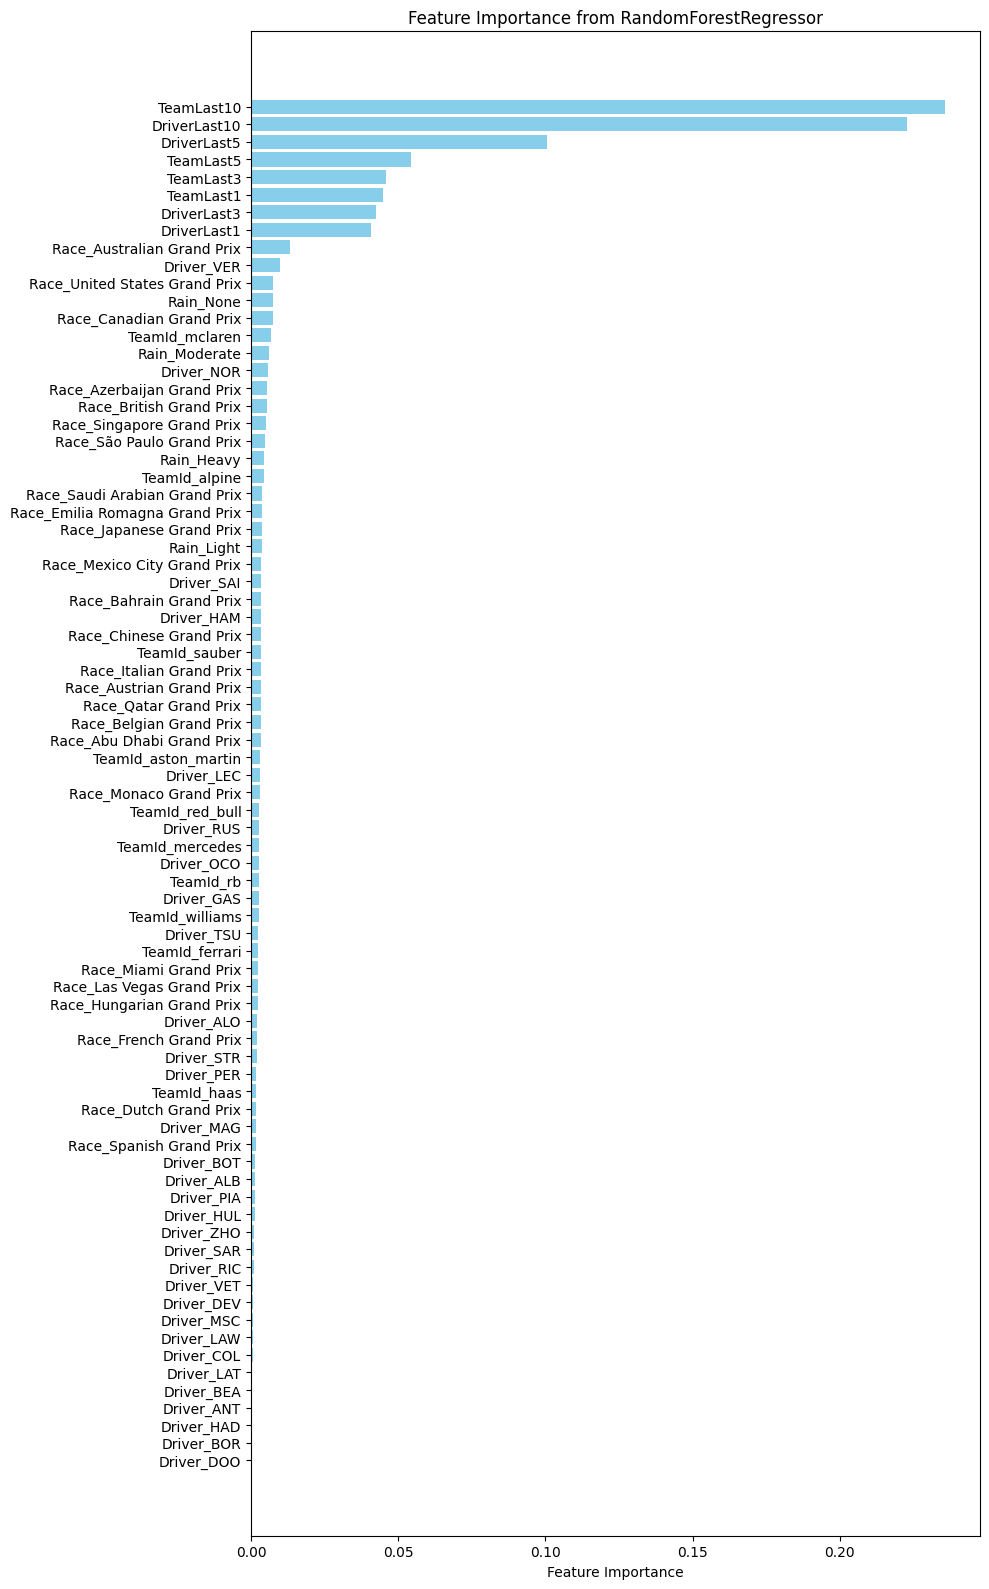

In [32]:
# Get the transformer for categorical features from your preprocessor
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get one-hot encoded feature names (e.g., "Driver_VER", etc.)
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# The final feature names are (typically) the numerical features first,
# followed by the transformed categorical features.
final_feature_names = list(numerical_features) + list(cat_feature_names)

# --- Step 2: Retrieve Feature Importances from the RandomForestRegressor ---
# Access the regressor within the pipeline
rf_model = model_pipeline.named_steps['regressor']

# Get the feature importances array
importances = rf_model.feature_importances_

# Create a DataFrame for convenience and sort by importance
importance_df = pd.DataFrame({
    'feature': final_feature_names,
    'importance': importances
})
importance_df.sort_values(by='importance', ascending=True, inplace=True)

# --- Step 3: Plot the Feature Importance Chart ---
plt.figure(figsize=(10, 16))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from RandomForestRegressor")
plt.tight_layout()
plt.show()